### ２次元の混合ガウス分布

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math

In [44]:
class Gauss_Model():
    def __init__(self):
        self.k = 3
        self.pai = [1/3,1/3,1/3]
        self.sample = []
        self.gauss = []
        self.ganma = []
        self.clus = ['r','b','g']
        self.first = 0
        self.flag = 0
        self.prev_log_likelihood = 0.0
        
        
    def dataset(self,mean,sigma,n):
        for i in range(self.k):
            samplesB = np.random.multivariate_normal(mean[i],sigma[i],n[i]).T
            if(i>=1):
                samplesA = np.column_stack((samplesA,samplesB))
            else:
                samplesA = samplesB
        self.sample = samplesA
        plt.scatter(self.sample[0],self.sample[1],color='g',marker='+',alpha=0.8)
        
    def make_gauss_model(self,ave,sigma):
        self.gauss = []
        for i in range(self.k):
            self.gauss.append(multivariate_normal(mean=ave[i],cov=sigma[i]))
    
    def plot_graph(self,gauss,ganma):
        plt.figure()
        x,y = np.meshgrid(np.linspace(min(self.sample[0]),max(self.sample[0]),1000),np.linspace(min(self.sample[1]),max(self.sample[1]),1000))
        pos = np.dstack((x,y))
        for i in range(self.k):
            z = gauss[i].pdf(pos)
            plt.contour(x, y, z,colors=self.clus[i],alpha=0.5)
        if self.first == 0:
            plt.scatter(self.sample[0],self.sample[1],color="g",marker='+',alpha=0.8)
        else:
            for i in range(len(self.sample[0])):
                plt.scatter(self.sample[0][i],self.sample[1][i],color=[ganma[i][0],ganma[i][2],ganma[i][1]],marker='+',alpha=0.8)
        self.first = 1
    
    def e_step(self,pai,gauss):
        self.ganma = []
        for i in range(len(self.sample[0])):
            sum_p = 0.0
            p=[]
            for j in range(self.k):
                sum_p += pai[j]*gauss[j].pdf([self.sample[0][i],self.sample[1][i]])
            for j in range(self.k):
                p.append(pai[j]*gauss[j].pdf([self.sample[0][i],self.sample[1][i]])/sum_p)
            self.ganma.append(p)
            
    def m_step(self,ganma):
        N = []
        self.g_mean = []
        self.g_sigma = []
        self.pai = []
        for i in range(self.k):
            sum_p = 0.0
            for j in range(len(self.sample[0])):
                sum_p += ganma[j][i]
            N.append(sum_p)
            
            #分布の中心の更新
            sum_x = 0.0
            sum_y = 0.0
            for j in range(len(self.sample[0])):
                sum_x += ganma[j][i]*self.sample[0][j]
                sum_y += ganma[j][i]*self.sample[1][j]
            self.g_mean.append([sum_x/N[i],sum_y/N[i]])
            
            #分布の共分散行列の更新
            sum_p = 0.0
            sigma = []
            sigma = [np.array([self.sample[0][j],self.sample[1][j]])-np.array([self.g_mean[i]]) for j in range(len(self.sample[0]))]
            
            self.g_sigma.append(sum([ganma[j][i]*sigma[j].T.dot(sigma[j])for j in range(len(self.sample[0]))])/N[i])
            self.pai.append(N[i]/len(self.sample[0]))
            
    def log_likelihood(self,pai,gauss):
        sum_l = 0.0
        for n in range(len(self.sample[0])):
            t = [pai[k]*gauss[k].pdf([self.sample[0][n],self.sample[1][n]]) for k in range(self.k)]
            sum_l += math.log1p(sum(t))
        
        after_log_likelihood = sum_l
        
        if self.prev_log_likelihood/after_log_likelihood > 0.999:
            self.flag = 1
        else:
            self.prev_log_likelihood = after_log_likelihood

repeat: 15
Gauss0:
pai: 0.447324172615
mean: [-5.0614021504393021, -5.0586053931803319]
cov: [[ 1.86969752  1.56144397]
 [ 1.56144397  1.94582812]]
Gauss1:
pai: 0.329090958831
mean: [-0.10542795997850567, 8.5470421381819391e-05]
cov: [[ 2.17896981 -1.01543915]
 [-1.01543915  2.07079802]]
Gauss2:
pai: 0.223584868554
mean: [4.8412179896088725, 4.8185474688067602]
cov: [[ 1.88907865  1.48756131]
 [ 1.48756131  1.7301286 ]]


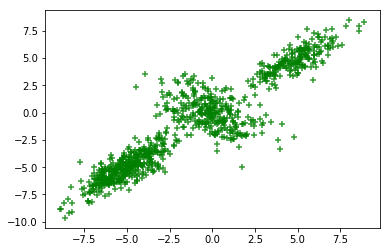

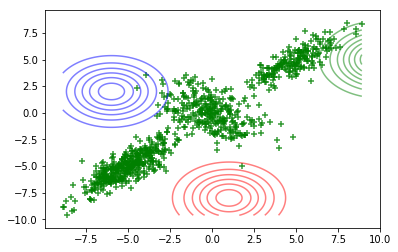

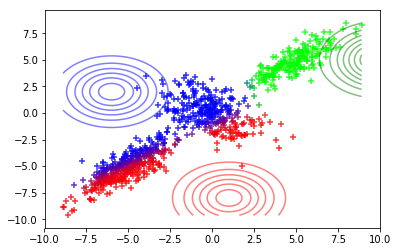

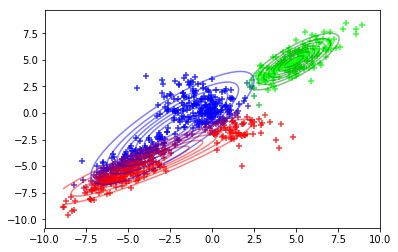

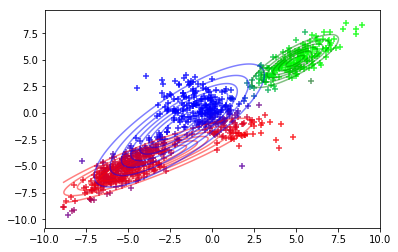

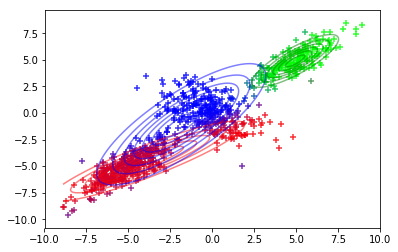

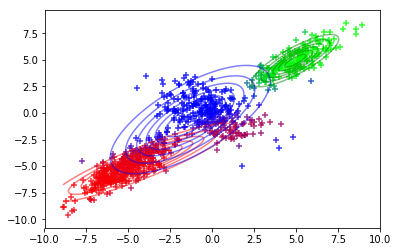

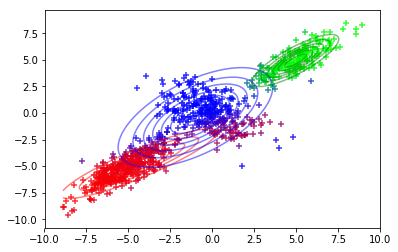

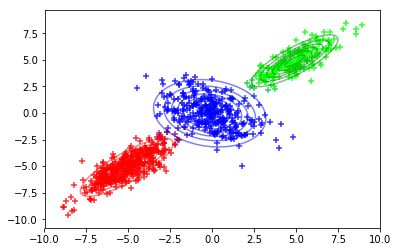

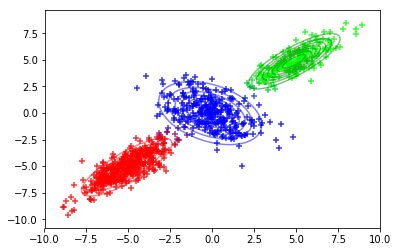

In [45]:
gm = Gauss_Model()
s_mean = [[-5,-5],[0,0],[5,5]]
s_sigma = [[[1.9,1.5],[1.5,1.9]],
        [[2.1,-1.0],[-1.0,2.1]],
          [[1.9,1.5],[1.5,1.9]]]
n = [400,300,200]
gm.dataset(s_mean,s_sigma,n)

g_mean = [[1,-8],[-6,2],[10,5]]
g_sigma = [[[3,0],[0,3]],
        [[3,0],[0,3]],
          [[3,0],[0,3]]]
gm.make_gauss_model(g_mean,g_sigma)
gm.plot_graph(gm.gauss,gm.ganma)

for i in range(99):
    gm.e_step(gm.pai,gm.gauss)
    if i % 4 == 0:
        gm.plot_graph(gm.gauss,gm.ganma)
    
    gm.m_step(gm.ganma)
    gm.make_gauss_model(gm.g_mean,gm.g_sigma)
    if i % 4 == 0:
        gm.plot_graph(gm.gauss,gm.ganma)
    gm.log_likelihood(gm.pai,gm.gauss)
    if gm.flag == 1:
        break
    
print("repeat:",i+1)
for k in range(gm.k):
    print("Gauss{0}:".format(k))
    print("pai:",gm.pai[k])
    print("mean:",gm.g_mean[k])
    print("cov:",gm.g_sigma[k])